In [25]:
!pip install -q transformers datasets tokenizers

# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

In [27]:
device = "cuda" if torch.cuda.is_available else "cpu"

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [28]:
emotion_dataset = load_dataset("emotion")

Using custom data configuration default
Reusing dataset emotion (/root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


  0%|          | 0/3 [00:00<?, ?it/s]

Посмотри, из чего состоит `emotion_dataset`:

In [29]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [30]:
emotion_dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [31]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [32]:
emotion_dataset["train"]["label"][0]

0

In [33]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [34]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [35]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [36]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [37]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [38]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [39]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [40]:
# Если надо, попрактикуйся работать с токенайзером здесь

In [41]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]["text"][idx]
        label = self.dataset[self.part]["label"][idx]
        
        tokenizer_output = self.tokenizer.encode_plus(text,max_length=self.max_length,padding = "max_length",return_tensors="pt")
        target = self.label2num[label]
        return {
            "input_ids": tokenizer_output['input_ids'], 
            "mask": tokenizer_output['attention_mask'],
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [42]:
train_dataset = TweetDataset("train")
valid_dataset = TweetDataset("validation")
test_dataset = TweetDataset("test")

In [43]:
batch_size = 64 # Задай batch_size

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size = batch_size
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = batch_size
)

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [44]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

Подготовь оптимайзер и критерий:

In [45]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_0.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [ ]:
tokens = train_dataset[0]['input_ids'].to(device) # Получи токены из датасета
mask = train_dataset[0]['mask'].to(device) # Получи маску из датасета

model_0(input_ids=tokens, attention_mask=mask) # Посмотри на аутпут


Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [48]:
from tqdm.notebook import tqdm


num_epochs = 8

# Train loop
for e in tqdm(range(num_epochs)):
    model_0.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        tokens, mask, target = batch["input_ids"].to(device).squeeze(1),batch['mask'].to(device).squeeze(1),torch.tensor(batch['target']).to(device)
        # model_0(input_ids=tokens, attention_mask=mask)
        res = model_0(input_ids=tokens, attention_mask=mask)
        logits = res.logits
        past_key_values = res.past_key_values
        attentions = res.attentions
        optimizer.zero_grad()

        loss=criterion(logits,target)
        loss.backward()
        optimizer.step()
        train_loss +=loss.item()
        
    valid_loss = 0
    valid_acc = 0.0
    model_0.eval()
    with torch.no_grad():
        for batch in valid_loader:
            tokens, mask, target = batch["input_ids"].to(device).squeeze(1),batch['mask'].to(device).squeeze(1),torch.tensor(batch['target']).to(device)
            res = model_0(input_ids=tokens, attention_mask=mask)
            logits = res.logits
            past_key_values = res.past_key_values
            attentions = res.attentions
            loss = criterion(logits, target)
            acc = (target == logits.max(1)[1]).float().sum()
            valid_loss += loss.item()
            valid_acc += acc/len(target)
           
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          # f"Valid Acc: {valid_acc}")
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
# Testing


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train Loss: 1.56998268699646,Valid Loss: 1.4554624371230602,Valid Acc: 0.41064453125


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 1.260223259449005,Valid Loss: 1.0482835471630096,Valid Acc: 0.6123046875


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.860555839061737,Valid Loss: 0.8069487791508436,Valid Acc: 0.72119140625


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.5909501155614852,Valid Loss: 0.6298388596624136,Valid Acc: 0.7822265625


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.4033274948000908,Valid Loss: 0.5228060912340879,Valid Acc: 0.8193359375


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.27463407173752785,Valid Loss: 0.47606039606034756,Valid Acc: 0.84228515625


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.19079918046295644,Valid Loss: 0.4636405911296606,Valid Acc: 0.85888671875


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.15050792073458433,Valid Loss: 0.4211279642768204,Valid Acc: 0.87841796875


In [49]:
test_acc = 0.0
model_0.eval()
with torch.no_grad():
    for batch in test_loader:
        tokens, mask, target = batch["input_ids"].to(device).squeeze(1),batch['mask'].to(device).squeeze(1),torch.tensor(batch['target']).to(device)
        res = model_0(input_ids=tokens, attention_mask=mask)
        logits = res.logits
        past_key_values = res.past_key_values
        attentions = res.attentions
        acc = (target == logits.max(1)[1]).float().sum()

        test_acc += acc/len(target)
print(f"Test Acc: {test_acc / len(test_loader)}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Test Acc: 0.8564453125


После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [50]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn)

In [51]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [52]:
text = emotion_dataset['test']['text'][100] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

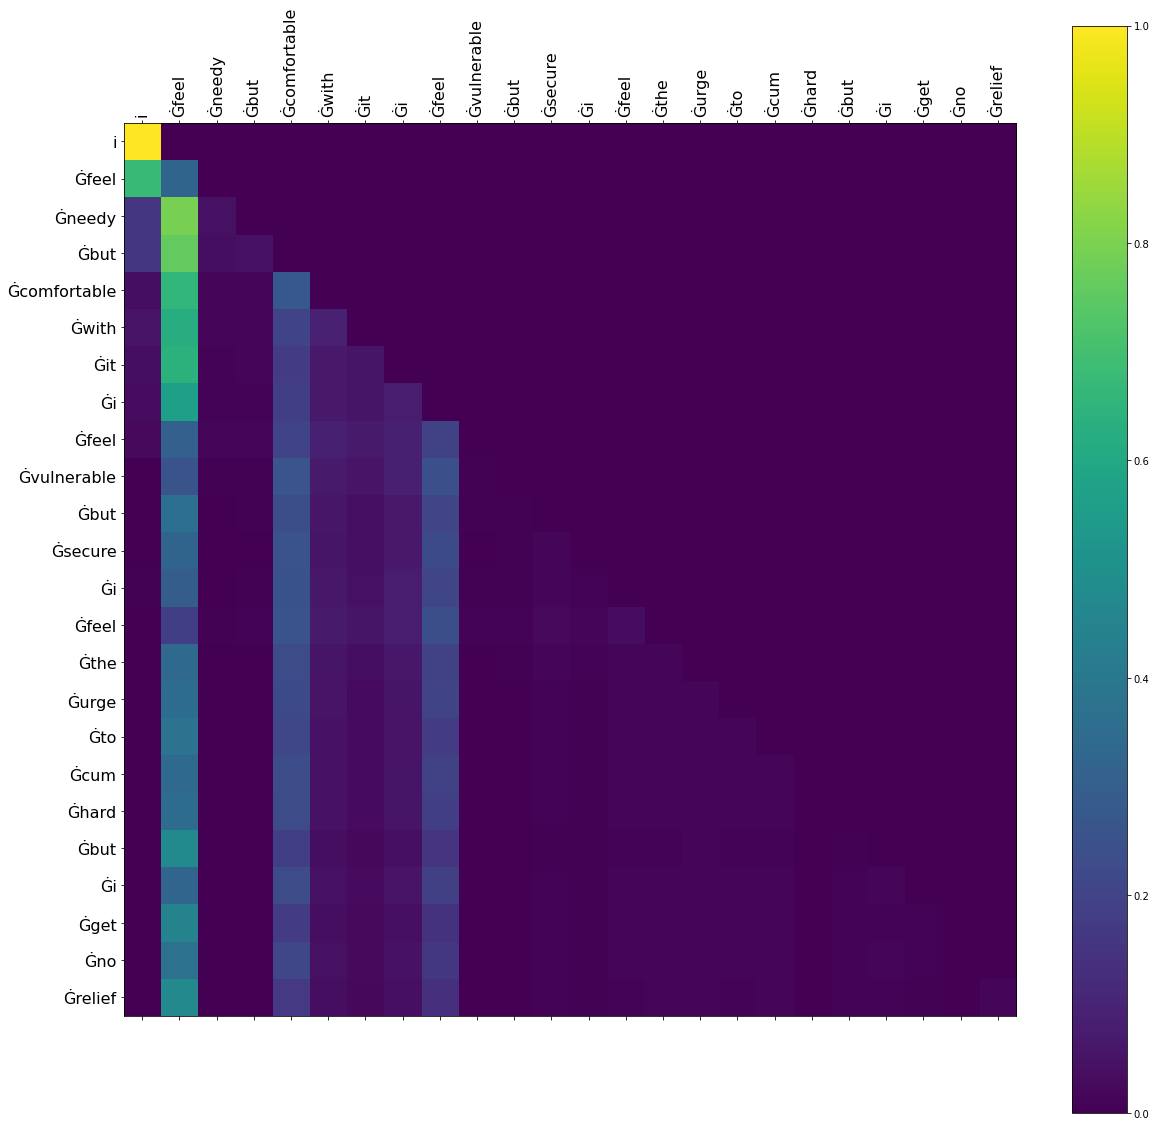

In [53]:
attn = get_attention_matrixes(model_0, tokenizer, text)
show_attention(tokens, attn[-1][0])

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [54]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8
).to(device)

Downloading:   0%|          | 0.00/336M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [55]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_1.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [56]:
from tqdm.notebook import tqdm


num_epochs = 8

# Train loop
for e in tqdm(range(num_epochs)):
    model_1.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        tokens, mask, target = batch["input_ids"].to(device).squeeze(1),batch['mask'].to(device).squeeze(1),torch.tensor(batch['target']).to(device)
        # model_0(input_ids=tokens, attention_mask=mask)
        res = model_1(input_ids=tokens, attention_mask=mask)
        logits = res.logits
        past_key_values = res.past_key_values
        attentions = res.attentions
        optimizer.zero_grad()

        loss=criterion(logits,target)
        loss.backward()
        optimizer.step()
        train_loss +=loss.item()
        
    valid_loss = 0
    valid_acc = 0.0
    model_1.eval()
    with torch.no_grad():
        for batch in valid_loader:
            tokens, mask, target = batch["input_ids"].to(device).squeeze(1),batch['mask'].to(device).squeeze(1),torch.tensor(batch['target']).to(device)
            res = model_1(input_ids=tokens, attention_mask=mask)
            logits = res.logits
            past_key_values = res.past_key_values
            attentions = res.attentions
            loss = criterion(logits, target)
            acc = (target == logits.max(1)[1]).float().sum()
            valid_loss += loss.item()
            valid_acc += acc/len(target)
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
# Testing
test_acc = 0.0
model_1.eval()
with torch.no_grad():
    for batch in test_loader:
        tokens, mask, target = batch["input_ids"].to(device).squeeze(1),batch['mask'].to(device).squeeze(1),torch.tensor(batch['target']).to(device)
        res = model_1(input_ids=tokens, attention_mask=mask)
        logits = res.logits
        past_key_values = res.past_key_values
        attentions = res.attentions
        acc = (target == logits.max(1)[1]).float().sum()

        test_acc += acc/len(target)
print(f"Test Acc: {test_acc / len(test_loader)}")

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train Loss: 1.469059531211853,Valid Loss: 0.8175172246992588,Valid Acc: 0.701171875


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.6166107161045075,Valid Loss: 0.39734752336516976,Valid Acc: 0.875


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.34651354283094404,Valid Loss: 0.26617284398525953,Valid Acc: 0.91064453125


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.24572677791118622,Valid Loss: 0.22180986171588302,Valid Acc: 0.91845703125


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.19746985571086406,Valid Loss: 0.19902475830167532,Valid Acc: 0.91845703125


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.17092433190345765,Valid Loss: 0.1823810376226902,Valid Acc: 0.92236328125


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.15170443028211594,Valid Loss: 0.16818096733186394,Valid Acc: 0.921875


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.13808675072342158,Valid Loss: 0.15916034358087927,Valid Acc: 0.9296875


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Test Acc: 0.92333984375


Есть ли прирост качества или скорости обучения?

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

In [57]:
text = emotion_dataset['test']['text'][100] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

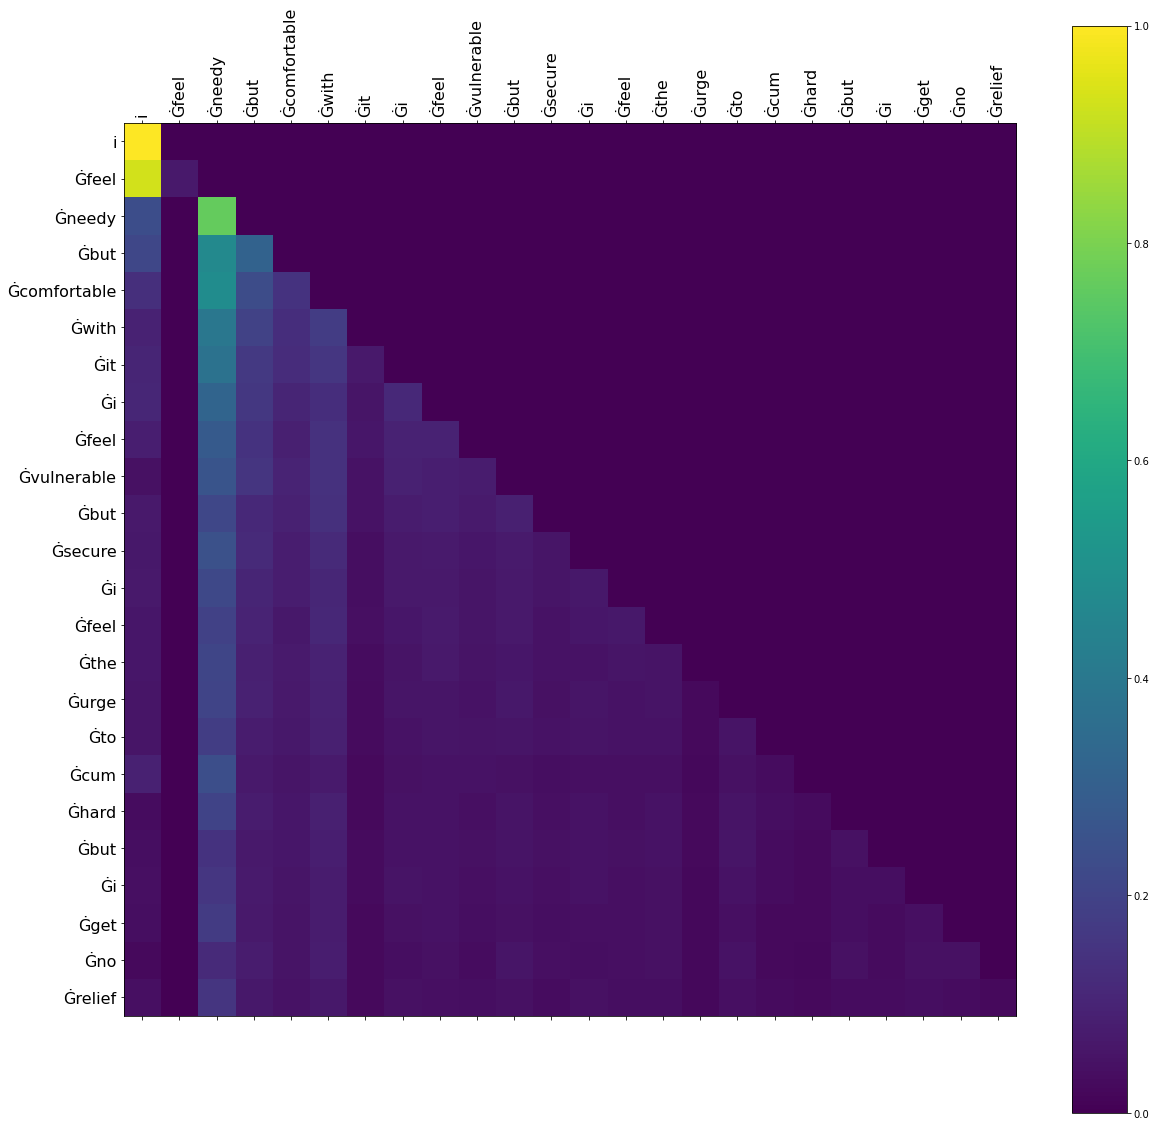

In [58]:
attn = get_attention_matrixes(model_1, tokenizer, text)
show_attention(tokens, attn[-1][0])

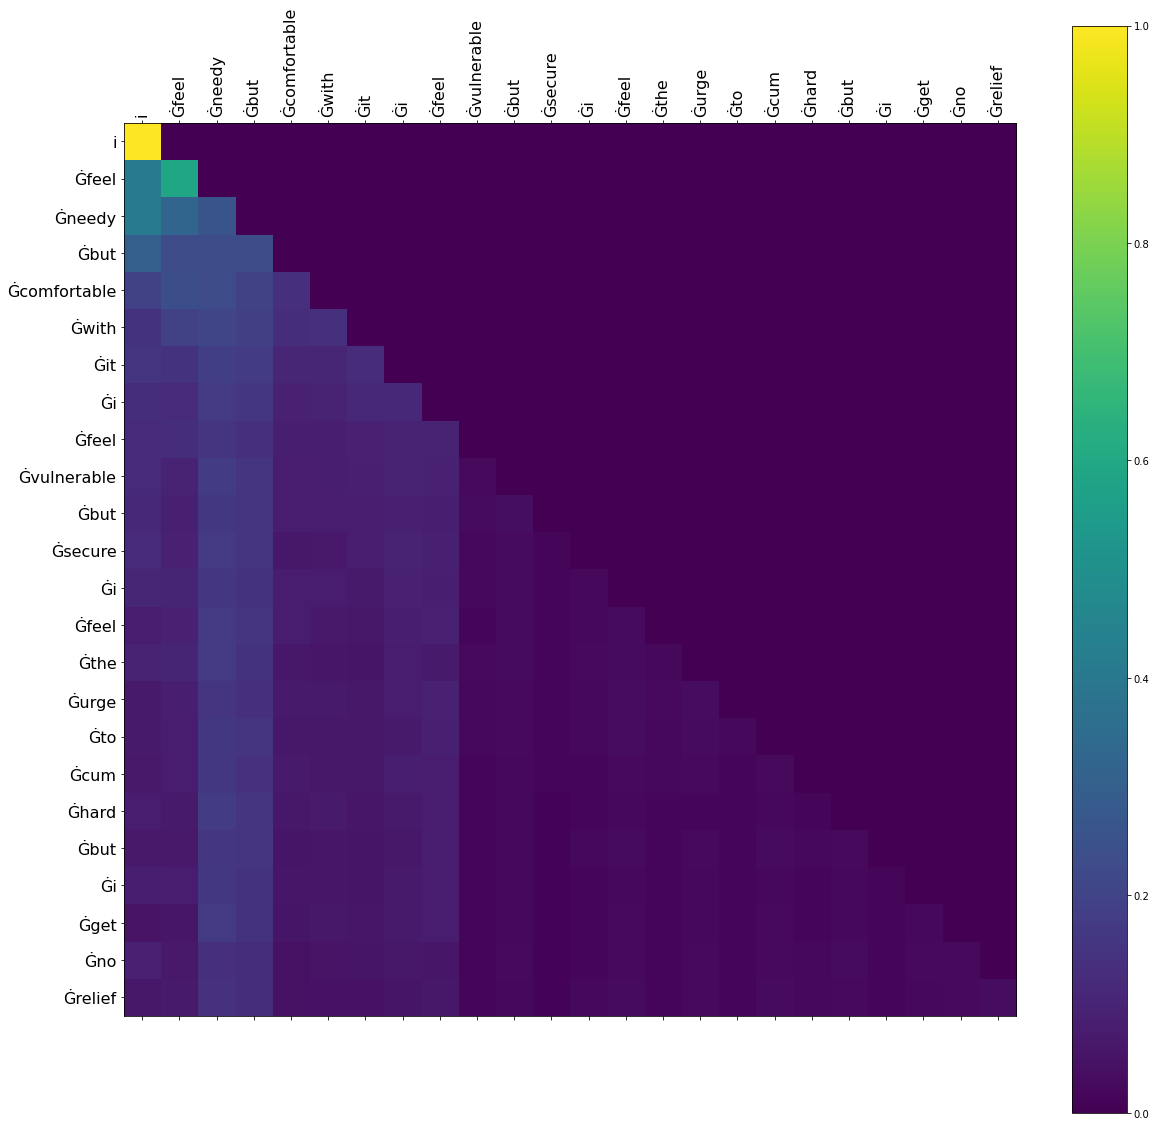

In [59]:
attn = get_attention_matrixes(model_0, tokenizer, text)
show_attention(tokens, attn[-3][3])

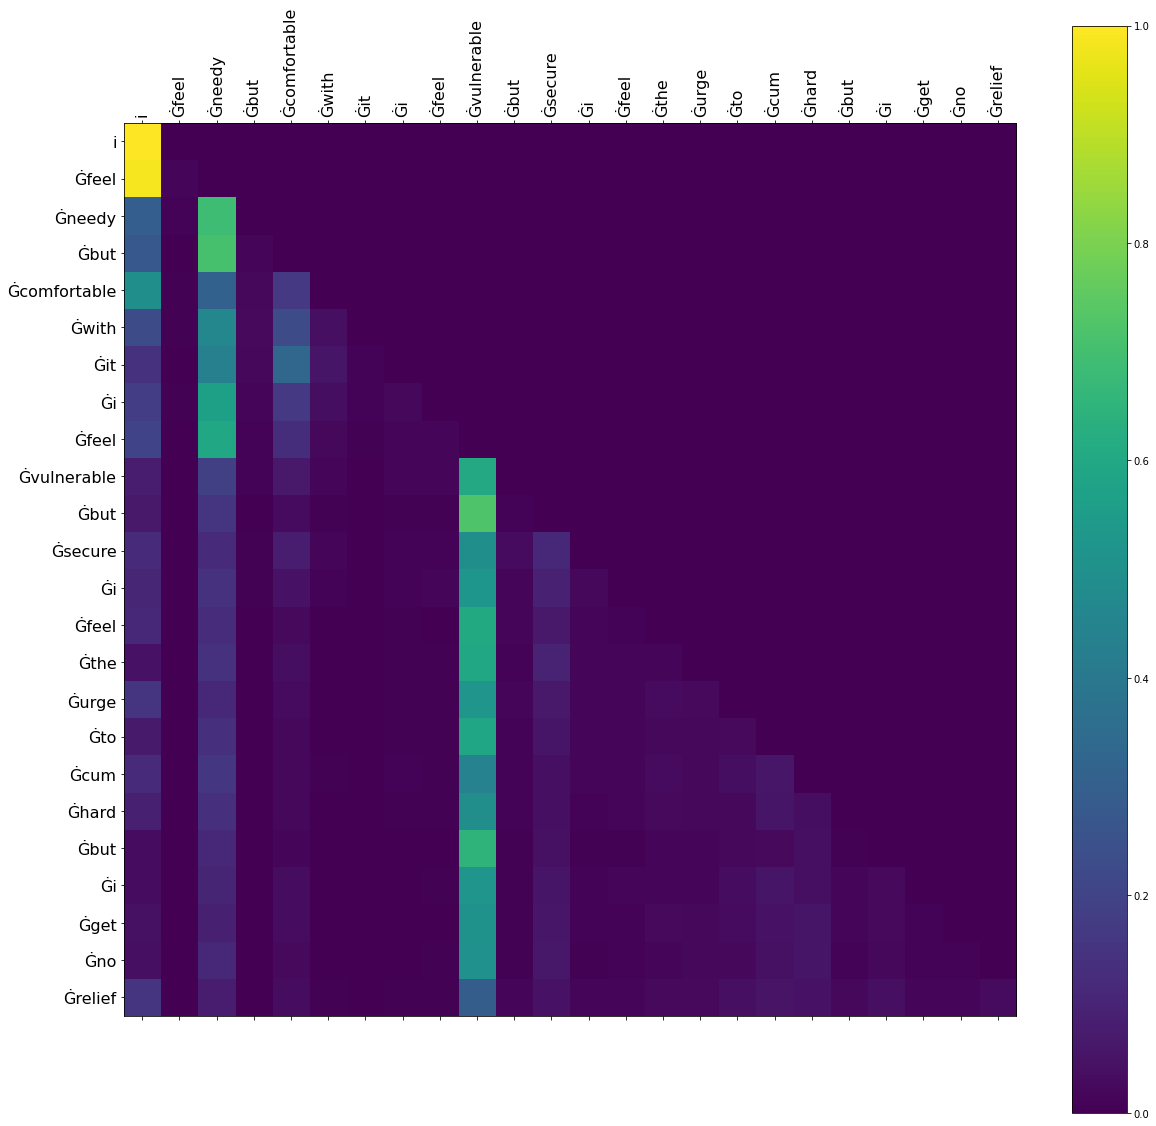

In [60]:
attn = get_attention_matrixes(model_1, tokenizer, text)
show_attention(tokens, attn[-3][3])

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Какой подход оказался лучше? 
- На какие слова модель большего всего обращала внимание?
- На каких слоях/головах модель обращала внимание?

< твой отчет/ответы >

1) второй подход оказался лучше (acc>0.92)

2-3) Первое слово всегда обращает внимание на себя самого. Дальше по картам внимания видно (например для 4й головы и для 3го слоя), что вторая модель замечает связь между популярными парами слов, например 'i' и 'feel' или 'but' и 'vulnerable'